## WIFI encrypted CLASSIFIER

A machine-learning classifier able to dis6nguish what kind of ac6vity a user is performing with his/her smartphone/laptop by sniffing traffic in monitor mode.

a. Sniff traffic in monitor mode from a known MAC address 

b.  extract statistical features from the traffic every W seconds:
  - number of packets up/down
  - average and variance of the packet size
  - average and variance of the inter-arrival packet times

  max, min, mean and standar deviation
  from a to b, control packets transport protocol

c. choose a pre-trained machine-learning classifier 
d. to recognize the user activity among at least the following
   - idle, web browsing, YouTube streaming
e. Report the accuracy of the approach through a confusion matrix

a. Sniff traffic in monitor mode from a known MAC address 

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display

# read each X seconds, take statistics
# ((wlan.sa == aa:3a:0e:b6:ed:12  or wlan.da == aa:3a:0e:b6:ed:12 ) ) && (wlan.fc.type_subtype == 0x0028)
SRC_MAC = 'aa:3a:0e:b6:ed:12'
# import csv
sniff = pd.read_csv('mobile_capture_filtered.csv')


treshold = sniff["Time"].min() #take minimun timestamp
W = 2 #secconds
def create_sampling(time):
    return math.floor( (time - treshold)/W )

sniff["sample_no"] = sniff["Time"].apply(create_sampling)
#display(sniff)



b.  extract statistical features from the traffic every W seconds:
  - number of packets up/down
  - average and variance of the packet size
  - average and variance of the inter-arrival packet times

  max, min, mean and standar deviation
  from a to b, control packets transport protocol

In [250]:
# create X
#   limpiar campos 
#   obtener solo del objective mac
#       original source (SA), final destination (DA), and the immediate sending/receiving systems (TA/RA)
#   obtener estatistiticas

# numero de pacotes up/down
data = sniff
data = data.set_index('sample_no')

# avrg and variance packet size
data["avrg_len"] = data.groupby(["sample_no"])["Length"].mean()
data["var_len"] = data.groupby(["sample_no"])["Length"].var(ddof=0)

# avrg and variance inter-arrival-times
data['IAT'] = data["Time"].diff()
data["avrg_IAT"] = data.groupby(["sample_no"])["IAT"].mean()
data["var_IAT"] = data.groupby(["sample_no"])["IAT"].var(ddof=0)


# packets count and down up link count
data["count"] = data.groupby(["sample_no"])["No."].transform('count')
data = data[data["Source"] == SRC_MAC] # get only uplink packets
data["upload_count"] = data.groupby(["sample_no"])["No."].transform('count')

data = data.drop(["Source","Destination","Protocol", "Length","Info","Time","IAT","No."],axis=1)
data=data.groupby("sample_no").agg({
    "avrg_IAT":"first",
    "avrg_IAT":"first",
    "var_IAT":"first",
    "upload_count":"first",
    "count":"first",
    "avrg_len":"first",
    "var_len":"first"}).reset_index()
#data.to_csv("output.csv")
display(data)

time =sniff["Time"].max() - sniff["Time"].min()
print("#packets :{} \n#time :{} ".format(data["count"].sum(), time ) )


,sample_no,avrg_IAT,var_IAT,upload_count,count,avrg_len,var_len
0,0,0.009065,0.000471,196,198,201.050505,17911.229772
1,1,0.002866,0.000227,748,769,261.111834,223279.152643
2,2,0.003226,0.000335,602,610,226.273770,146087.356197
3,3,0.003085,0.000317,618,638,269.747649,253481.915943
4,4,0.010119,0.001066,196,205,316.009756,334447.873076
...,...,...,...,...,...,...,...
147,168,0.046910,0.018382,41,41,305.024390,53526.657942
148,169,0.010462,0.001044,188,188,309.505319,97882.228695
149,170,0.027054,0.007402,74,74,242.972973,23160.783053
150,171,0.087789,0.010238,19,19,467.684211,222145.163435


#packets :47135 
#time :344.07273620200004 


In [248]:
# create gt
#   clasificar con base en las estadisticas
def get_ground_truth(upload_count):
    N = 75
    if upload_count < N:
        return "youtube"
    elif upload_count < 2*N:
        return "idle"
    elif upload_count < 3*N:
        return "web_browser"
    else:
        return "streaming"


c. choose a pre-trained machine-learning classifier 
d. to recognize the user activity among at least the following
   - idle, web browsing, YouTube streaming
e. Report the accuracy of the approach through a confusion matrix

0.8552631578947368
0.8552631578947368
0.881578947368421
0.9078947368421053


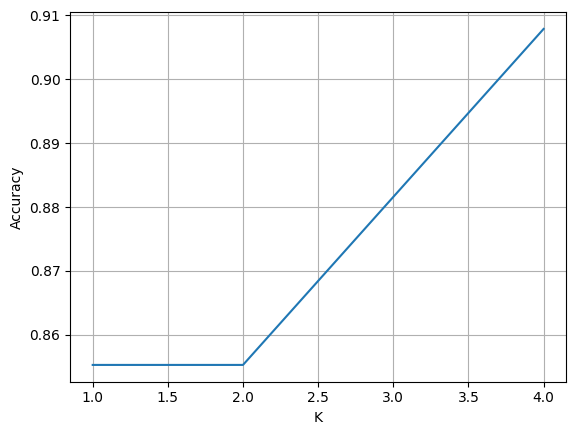

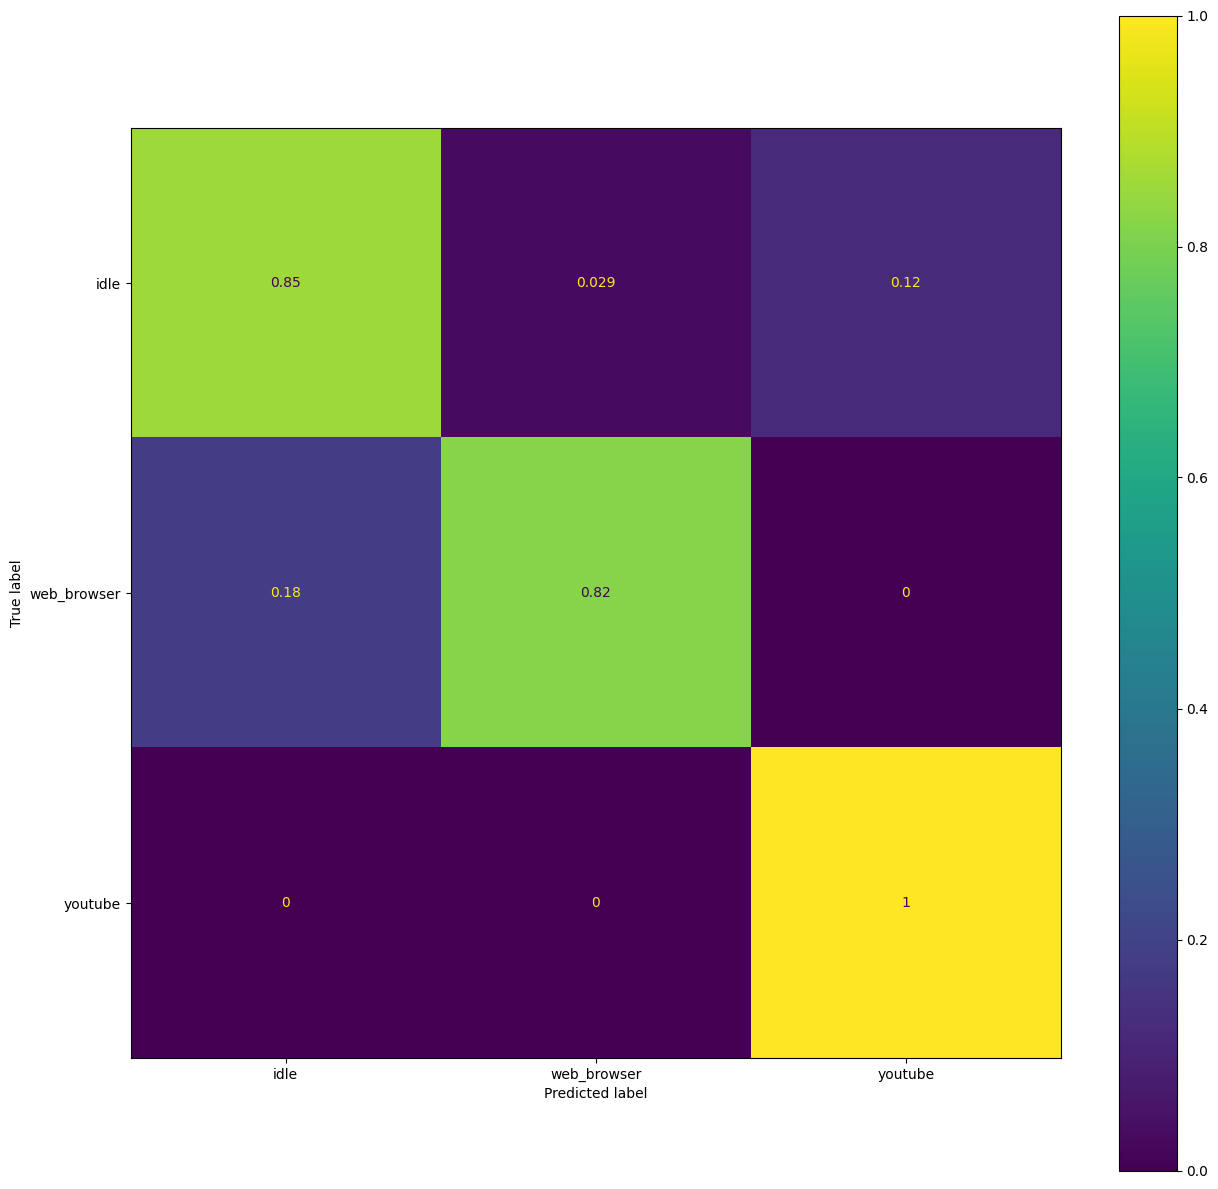

In [249]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

scaler = StandardScaler()

X = data.dropna()
Y = data["sample_no"].apply(get_ground_truth)

X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.5)

ACCURACY = []
for k in range(1,5):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  print(accuracy)

fig = plt.figure();
plt.plot(range(1,5),ACCURACY);
plt.grid(visible=True);
plt.xlabel('K');
plt.ylabel('Accuracy');

bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true')


